In [87]:
#!pip install yfinance
import yfinance as yf # https://pypi.org/project/yfinance/
import math
from numpy.core.numeric import ones_like
import random
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import pandas as pd

In [88]:
# get data by ticker-name, start-time & end-time
def get_df_data(ticker_name="AAPL", start_time="2022-01-01", end_time="2022-10-09"):
  df_data = yf.download(tickers=ticker_name, start=start_time, end=end_time) 
  return df_data

# calculate the daily return by (current_index - previous_index) / previous_index
def calculate_daily_return(df_data, OHLC_index="Close"):
  name1 = OHLC_index+"_previous"
  df_data[name1] = df_data[OHLC_index].shift(1)
  name2 = OHLC_index+"_delta"
  df_data[name2] = df_data[OHLC_index] - df_data[name1]
  name3 = OHLC_index+"_return"
  df_data[name3] = df_data[name2] / df_data[name1]
  del df_data[name1]
  del df_data[name2]
  #new_feature = name3
  return df_data #, new_feature

# get the market movement (yesterday -> today) based on daily return, 
  # 1 means rise and 0 fall
def get_market_movement(df_data, signal_name="Close_return"):
  df_data["movement"] = df_data[signal_name]>0
  df_data["movement"] = df_data["movement"].astype(int)
  return df_data

# convert the time to be string type: yyyy-mm-dd
  # get month number & week number
def get_ymt_date(df_data):
  df_data["ymd_time"] = df_data.index
  df_data["ymd_time"] = df_data["ymd_time"].astype(str)
  df_data["ymd_time"] = df_data["ymd_time"].str.slice(0,10)
  # year
  df_data["yearNumber"] = df_data["ymd_time"].str.slice(0,4)
  df_data["yearNumber"] = df_data["yearNumber"].astype(int)
  year_list = list( set(df_data["yearNumber"]) )
  year_list = sorted(year_list)
  year_start, year_end = year_list[0], year_list[-1]
  # month
  df_data["monthNumber"] = df_data["ymd_time"].str.slice(5,7)
  df_data["monthNumber"] = df_data["monthNumber"].astype(int)
  df_data["monthNumber_update"] = (df_data["yearNumber"]-year_start)*12 + df_data["monthNumber"] # every year has 12 months
  # week
  df_data['ymd_time'] = pd.to_datetime(df_data['ymd_time'], errors ='coerce')
  df_data['weekNumber'] = df_data['ymd_time'].dt.isocalendar().week
  df_data['weekNumber_update'] = (df_data["yearNumber"]-year_start)*52 + df_data["weekNumber"] # every year has 52 weeks
  # week of day
  df_data['weekday'] = df_data['ymd_time'].dt.dayofweek
  return df_data

def weekday_analysis(df_data, mode=0):
    tmp_data = df_data.copy()
    week_num = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
    weekdays = sorted( list( set( list(tmp_data['weekday']) ) ) )
    #info_list = []
    x_axis, y_axis = [], []
    for wd in weekdays:
        tmp_df = tmp_data[tmp_data['weekday']==wd]
        feature = 'Close_return'
        if mode == 1:
            feature = 'Open_Close_dif'
        pos = len( tmp_df[ tmp_df[feature]>0 ] )
        neg = len( tmp_df[ tmp_df[feature]<0 ] )
        #info_list.append( (wd, pos, neg) )
        r1, r2 = round(pos*100/(pos+neg), 2), round(neg*100/(pos+neg), 2)
        print( week_num[wd] )
        print( "\t rise vs fall (d):", pos, neg  )
        print( "\t rise vs fall (%):", r1, r2  )
        #
        x_axis.append( wd*2 )
        y_axis.append( r1 )
        x_axis.append( wd*2+1 )
        y_axis.append( r2 )
    return x_axis, y_axis

def get_weekly_data(tmp_data, wn, feature):
    if wn<1:
        return []
    tmp_df = tmp_data[ tmp_data['weekNumber_update']==wn ]
    return list( tmp_df[feature] )

def weekly_analysis(df_data, mode=0):
    tmp_data = df_data.copy()
    weekNumbers = sorted( list( set( tmp_data['weekNumber_update'] ) ) )
    x_axis, y_axis = [], []
    for wn in weekNumbers[:]:
        weekly_return = 0
        if mode==0: # current week last close - previous week last close
            feature = "Close"
            current_week = get_weekly_data(tmp_data, wn, feature)
            previous_week = get_weekly_data(tmp_data, wn-1, feature)
            if len(previous_week)<1:
                weekly_return = 0
            else:
                weekly_return = (current_week[-1] - previous_week[-1])/previous_week[-1]
        elif mode==1: # current week last close - current week first open
            current_open = get_weekly_data(tmp_data, wn, "Open")
            current_close = get_weekly_data(tmp_data, wn, "Close")
            weekly_return = (current_close[-1] - current_open[0])/current_open[0]
        else: # current week last close - current week first close
            current_close = get_weekly_data(tmp_data, wn, "Close")
            weekly_return = (current_close[-1] - current_close[0])/current_close[0]
        x_axis.append(wn)
        y_axis.append( round(weekly_return*100, 2) )
    return x_axis, y_axis

def get_monthly_data(tmp_data, mn, feature):
    if mn<1:
        return []
    tmp_df = tmp_data[ tmp_data['monthNumber_update']==mn ]
    return list( tmp_df[feature] )

#get_monthly_data( df_data, 11, "Close" )
def monthly_analysis(df_data, mode=0):
    tmp_data = df_data.copy()
    monthNumbers = sorted( list( set( tmp_data['monthNumber_update'] ) ) )
    x_axis, y_axis = [], []
    for mn in monthNumbers[:]:
        monthly_return = 0
        if mode==0: # current month last close - previous month last close
            feature = "Close"
            current_close = get_monthly_data(tmp_data, mn, feature)
            previous_close = get_monthly_data(tmp_data, mn-1, feature)
            if len(previous_close)<1:
                monthly_return = 0
            else:
                monthly_return = (current_close[-1] - previous_close[-1])/previous_close[-1]
        elif mode==1: # current month last close - current month first open
            current_open = get_monthly_data(tmp_data, mn, "Open")
            current_close = get_monthly_data(tmp_data, mn, "Close")
            monthly_return = (current_close[-1] - current_open[0])/current_open[0]
        else: # current month last close - current month first close
            current_close = get_monthly_data(tmp_data, mn, "Close")
            monthly_return = (current_close[-1] - current_close[0])/current_close[0]
        x_axis.append(mn)
        y_axis.append( round(monthly_return*100, 2) )
    return x_axis, y_axis

# draw bar chart
def draw_bar(x_axis, y_axis, x_name, y_name, tn, title_name="", xt=None):
    data = {
            x_name: x_axis,
            y_name: y_axis
           }
    df = pd.DataFrame(data, columns=[x_name, y_name])
    # Defining the plot size
    # Defining the values for x-axis, y-axis
    # and from which dataframe the values are to be picked
    fig, ax = plt.subplots(figsize=(20, 6))
    plots = sns.barplot(x=x_name, y=y_name, data=df)
    if xt is not None:
        ax.set_xticks(x_axis)
        ax.set_xticklabels(xt) # , rotation=90

    # Iterrating over the bars one-by-one
    for bar in plots.patches:
        # Using Matplotlib's annotate function and
        # passing the coordinates where the annotation shall be done
        plots.annotate(format(bar.get_height(), '.2f'),
                       (bar.get_x() + bar.get_width() / 2,
                        bar.get_height()), ha='center', va='center',
                       size=12, xytext=(0, 5),
                       textcoords='offset points')
    # Setting the title for the graph
    plt.title("Stock: " + tn + " " + title_name)
    # Finally showing the plot
    plt.show()
    return 

In [89]:
### step 1: data preparation
# 0005.HK:滙豐控股, 1299.HK:友邦保險, 0700.HK:騰訊控股, 9988.HK:阿⾥巴巴, 3690.HK:美團 # AAPL
hk_tickers = ["3690.HK", "9618.HK", "1024.HK", "9866.HK"]
tn = "9988.HK" 
st, et = "2022-01-01", "2022-12-31"
df_data = get_df_data(ticker_name=tn, start_time=st, end_time=et)
df_data = calculate_daily_return(df_data) # daily return = (today close - yesterday close)/yesterday close
df_data['Open_Close_dif'] = (df_data['Close'] - df_data['Open'])/df_data['Open'] # 
df_data = get_market_movement(df_data) # daily return > 0 -> rise noted as 1, # daily return < 0 -> fall noted as 0
df_data = get_ymt_date(df_data)

date_list = list(df_data.index)
start_date, end_date = date_list[0], date_list[-1]
start_date, end_date = str(start_date)[:10], str(end_date)[:10]
title_name = "from " + start_date + " to " + end_date

df_data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Close_return,Open_Close_dif,movement,ymd_time,yearNumber,monthNumber,monthNumber_update,weekNumber,weekNumber_update,weekday
Date,,,,,,,,,,,,,,,,
2022-01-03,117.000000,117.500000,114.000000,115.000000,115.000000,22176946,NaN,-0.017094,0,2022-01-03,2022,1,1,1,1,0
2022-01-04,118.400002,118.900002,115.699997,116.900002,116.900002,23228903,0.016522,-0.012669,1,2022-01-04,2022,1,1,1,1,1
2022-01-05,119.000000,119.099998,113.900002,114.500000,114.500000,30717509,-0.020530,-0.037815,0,2022-01-05,2022,1,1,1,1,2
2022-01-06,117.500000,121.099998,117.300003,121.000000,121.000000,47231895,0.056769,0.029787,1,2022-01-06,2022,1,1,1,1,3
2022-01-07,126.500000,128.800003,122.800003,128.800003,128.800003,58778943,0.064463,0.018182,1,2022-01-07,2022,1,1,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-25,75.900002,76.000000,73.849998,74.750000,74.750000,28359869,-0.021597,-0.015152,0,2022-11-25,2022,11,11,47,47,4
2022-11-28,70.599998,73.349998,69.800003,72.199997,72.199997,65982901,-0.034114,0.022663,0,2022-11-28,2022,11,11,48,48,0
2022-11-29,73.650002,78.800003,73.199997,78.750000,78.750000,94542048,0.090720,0.069246,1,2022-11-29,2022,11,11,48,48,1


current close - previous close
Monday
	 rise vs fall (d): 12 31
	 rise vs fall (%): 27.91 72.09
Tuesday
	 rise vs fall (d): 21 23
	 rise vs fall (%): 47.73 52.27
Wednesday
	 rise vs fall (d): 19 28
	 rise vs fall (%): 40.43 59.57
Thursday
	 rise vs fall (d): 18 28
	 rise vs fall (%): 39.13 60.87
Friday
	 rise vs fall (d): 24 21
	 rise vs fall (%): 53.33 46.67


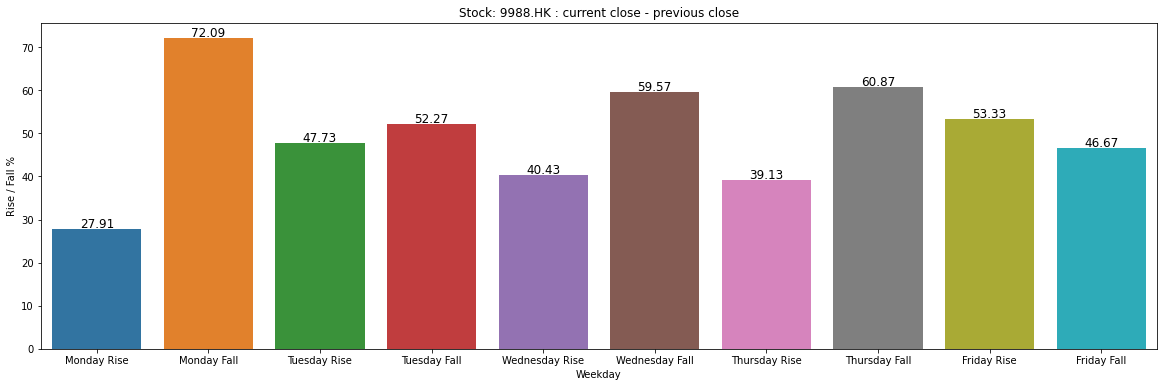

current close - current open
Monday
	 rise vs fall (d): 17 26
	 rise vs fall (%): 39.53 60.47
Tuesday
	 rise vs fall (d): 24 21
	 rise vs fall (%): 53.33 46.67
Wednesday
	 rise vs fall (d): 21 23
	 rise vs fall (%): 47.73 52.27
Thursday
	 rise vs fall (d): 16 30
	 rise vs fall (%): 34.78 65.22
Friday
	 rise vs fall (d): 23 18
	 rise vs fall (%): 56.1 43.9


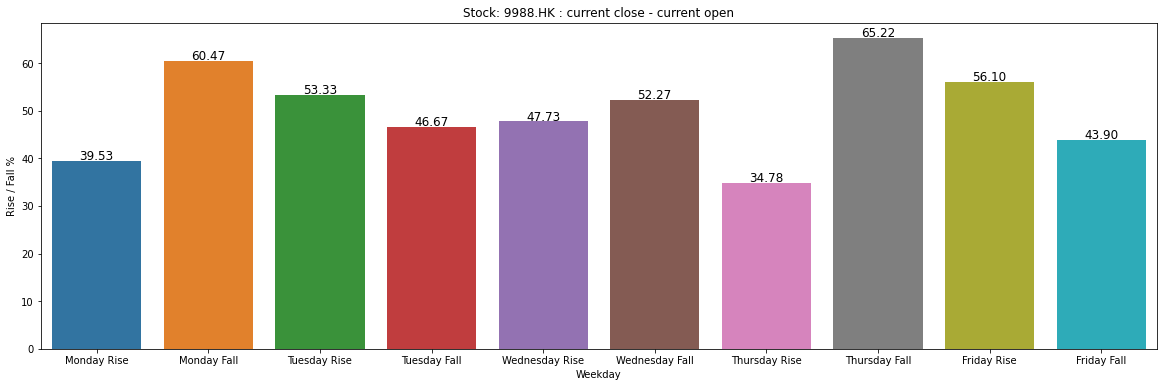

In [90]:
### step 2: show weekday analysis
x_name, y_name = "Weekday", "Rise / Fall %"
rename_xt = [
     'Monday Rise', 'Monday Fall', 'Tuesday Rise', 'Tuesday Fall', 'Wednesday Rise', 'Wednesday Fall',
     'Thursday Rise', 'Thursday Fall', 'Friday Rise', 'Friday Fall'
     ]
print( "current close - previous close" )
title_name = ": current close - previous close" 
x_axis, y_axis = weekday_analysis(df_data, 0)
draw_bar(x_axis, y_axis, x_name, y_name, tn, title_name, rename_xt)
print( "current close - current open" )
title_name = ": current close - current open" 
x_axis, y_axis = weekday_analysis(df_data, 1)
draw_bar(x_axis, y_axis, x_name, y_name, tn, title_name, rename_xt)

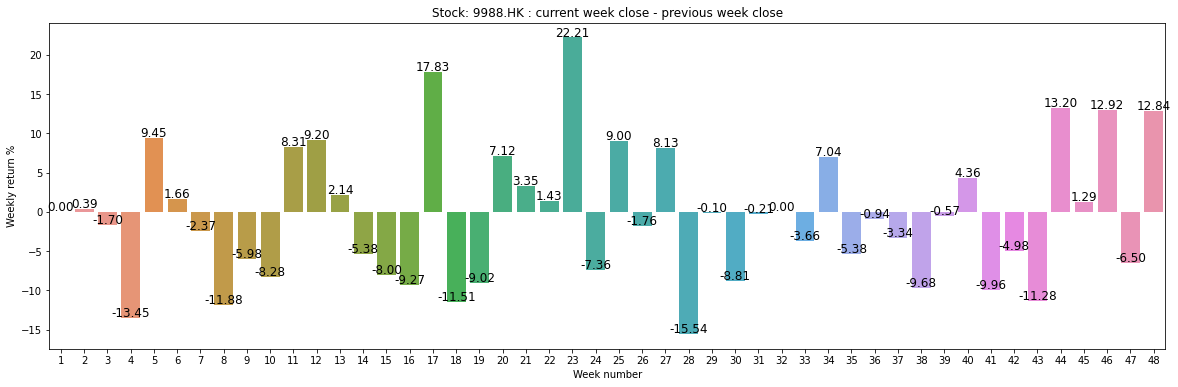

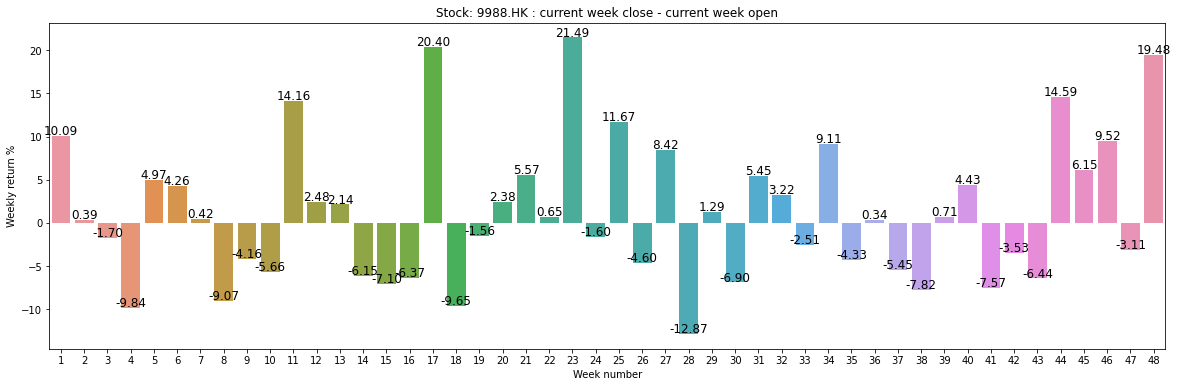

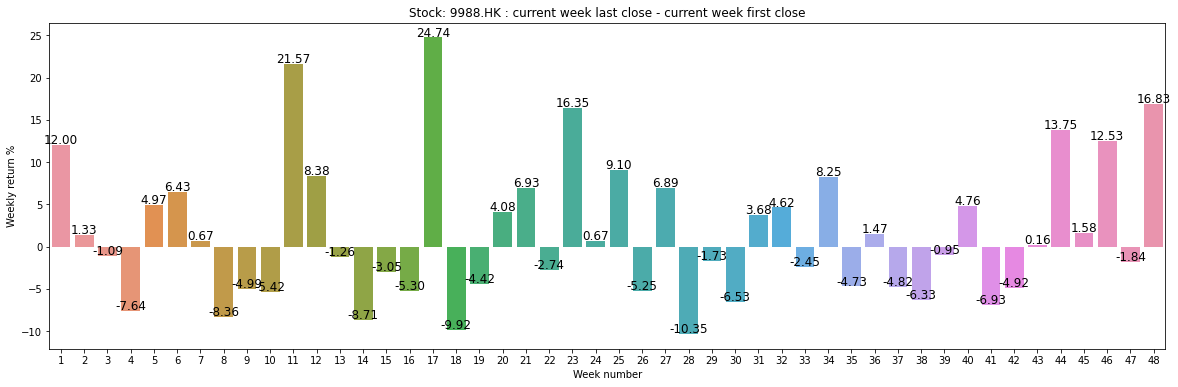

In [91]:
### step 3: show weekly analysis
x_name, y_name = "Week number", "Weekly return %"
title_name = ": current week close - previous week close"
x_axis, y_axis = weekly_analysis(df_data, 0)
draw_bar(x_axis, y_axis, x_name, y_name, tn, title_name, None)
title_name = ": current week close - current week open" 
x_axis, y_axis = weekly_analysis(df_data, 1)
draw_bar(x_axis, y_axis, x_name, y_name, tn, title_name, None)
title_name = ": current week last close - current week first close" 
x_axis, y_axis = weekly_analysis(df_data, 2)
draw_bar(x_axis, y_axis, x_name, y_name, tn, title_name, None)

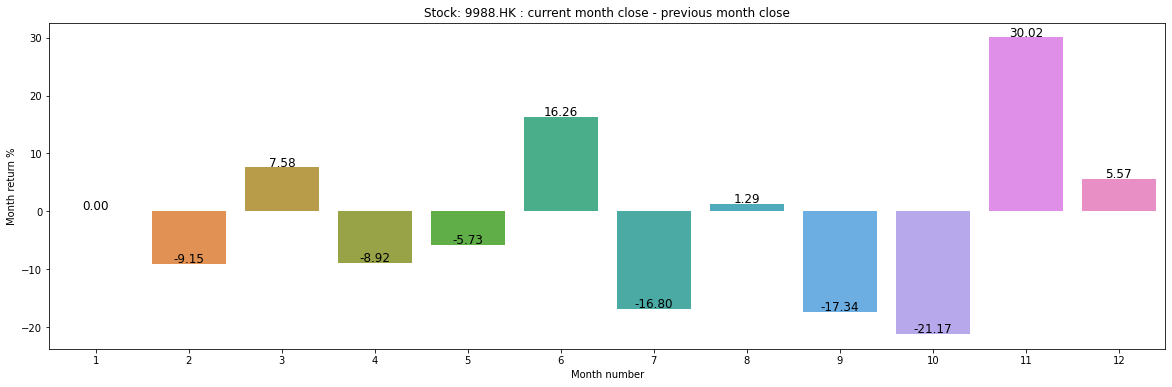

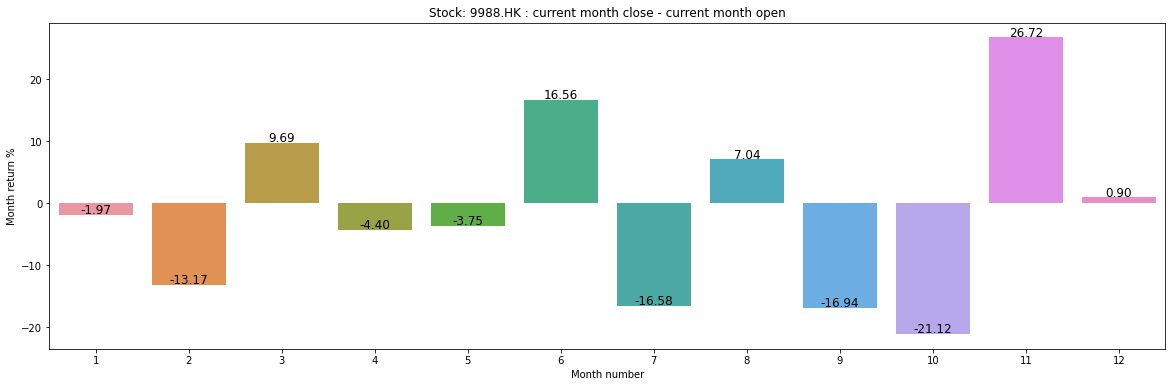

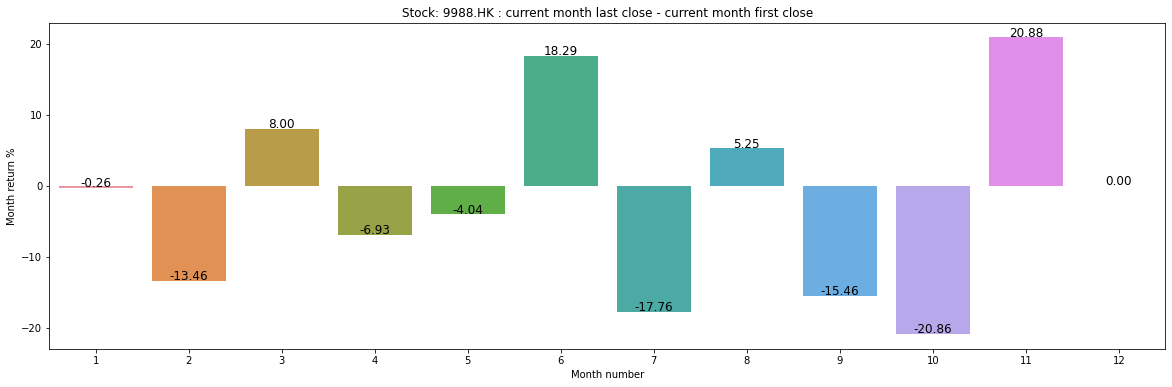

In [92]:
### step 4: show monthly analysis
x_name, y_name = "Month number", "Month return %"
title_name = ": current month close - previous month close"
x_axis, y_axis = monthly_analysis(df_data, 0)
draw_bar(x_axis, y_axis, x_name, y_name, tn, title_name, None)
title_name = ": current month close - current month open" 
x_axis, y_axis = monthly_analysis(df_data, 1)
draw_bar(x_axis, y_axis, x_name, y_name, tn, title_name, None)
title_name = ": current month last close - current month first close" 
x_axis, y_axis = monthly_analysis(df_data, 2)
draw_bar(x_axis, y_axis, x_name, y_name, tn, title_name, None)